# Goal:

In this assignment, you will implement a [DDPM](https://arxiv.org/abs/2006.11239) class on MNIST dataset using PyTorch according to the guidence. The goal is to minimize the loss function and train the model to generate MNIST images.

The `Train` and `UNet` classes are already implemented for you. You need to implement the `DDPM` class (see details below). The images generated by the model will be automatically shown according to the `Trainer` class implementation. Make sure the generated images are shown in the output, it will be graded.

Grade:
- **DDPM class implementation (20 points).**
- **Training the model to generate reasonable MNIST images within 20 epochs (10 points).**
- **Write a report to describe include the sample images generated by each epochs (10 points). Please note that the function to generate the image is already provided.**
---
Please DO NOT change the code provided, only add your own code where indicated. It is recommended that you **use CPU session to debug** when GPU is not necessary since Colab only gives 12 hrs of free GPU access at a time. If you use up the GPU resource, you may consider using Kaggle GPU resource. Thank you and good luck!

# Pre-determined config and given functions (no need to change)

In [1]:
!pip install labml_nn labml labml_helpers --no-deps
import torch
import torch.utils.data
import torchvision
from torch import nn
from labml_nn.diffusion.ddpm.unet import UNet
from typing import Tuple, Optional
import torch.nn.functional as F
from tqdm import tqdm
from easydict import EasyDict
import matplotlib.pyplot as plt
from torch.cuda.amp import GradScaler, autocast

args = {
    "image_channels": 1,  # Number of channels in the image. 3 for RGB.
    "image_size": 32,  # Image size
    "n_channels": 64,  # Number of channels in the initial feature map
    "channel_multipliers": [
        1,
        2,
        2,
        4,
    ],  # The list of channel numbers at each resolution.
    "is_attention": [
        False,
        False,
        False,
        True,
    ],  # The list of booleans for attention at each resolution
    "n_steps": 1000,  # Number of time steps T
    "nb_save": 5,  # Number of images to save
    "batch_size": 256,  # Batch size
    "n_samples": 16,  # Number of samples to generate
    "learning_rate": 2e-5,  # Learning rate
    "epochs": 20,  # Number of training epochs
    "device": "cuda" if torch.cuda.is_available() else "cpu",  # Device
    "fp16_precision": False
}
args = EasyDict(args)

In [2]:
class MNISTDataset(torchvision.datasets.MNIST):
    def __init__(self):
        transform = torchvision.transforms.Compose(
            [
                torchvision.transforms.Resize(args.image_size),
                torchvision.transforms.ToTensor(),
            ]
        )

        super().__init__(
            ".", train=True, download=True, transform=transform
        )

    def __getitem__(self, item):
        return super().__getitem__(item)[0]

In [3]:
class Trainer:
    def __init__(self, args, DenoiseDiffusion):

        self.eps_model = UNet(
            image_channels=args.image_channels,
            n_channels=args.n_channels,
            ch_mults=args.channel_multipliers,
            is_attn=args.is_attention,
        ).to(args.device)

        self.diffusion = DenoiseDiffusion(
            eps_model=self.eps_model,
            n_steps=args.n_steps,
            device=args.device,
        )

        self.optimizer = torch.optim.Adam(
            self.eps_model.parameters(), lr=args.learning_rate
        )
        self.args = args

    def train_a_round(self, dataloader, scaler):
        for data in dataloader:
            # Move data to device
            data = data.to(args.device)

            # Calculate the loss
            with autocast(enabled=self.args.fp16_precision):
                loss = self.diffusion.loss(data)
            # Zero gradients
            self.optimizer.zero_grad()
            # Backward pass
            scaler.scale(loss).backward()
            scaler.step(self.optimizer)
            scaler.update()

    def run_in_a_row(self, dataloader):
        scaler = GradScaler(enabled=self.args.fp16_precision)
        for current_epoch in tqdm(range(self.args.epochs)):
            self.current_epoch = current_epoch
            self.train_a_round(dataloader, scaler)
            self.sample()

    def sample(self):
        with torch.no_grad():
            # $x_T \sim p(x_T) = \mathcal{N}(x_T; \mathbf{0}, \mathbf{I})$
            x = torch.randn(
                [
                    self.args.n_samples,
                    self.args.image_channels,
                    self.args.image_size,
                    self.args.image_size,
                ],
                device=self.args.device,
            )
            if self.args.nb_save is not None:
                saving_steps = [self.args["n_steps"] - 1]
            # Remove noise for $T$ steps
            for t_ in tqdm(range(self.args.n_steps)):
                # $t$
                t = self.args.n_steps - t_ - 1
                # Sample from $\textcolor{lightgreen}{p_\theta}(x_{t-1}|x_t)$
                x = self.diffusion.p_sample(
                    x, x.new_full((self.args.n_samples,), t, dtype=torch.long)
                )
                if self.args.nb_save is not None and t_ in saving_steps:
                    print(f"Showing/saving samples from epoch {self.current_epoch}")
                    show_save(
                        x,
                        show=True,
                        save=True,
                        file_name=f"epoch_{self.current_epoch}_sample_{t_}.png",
                    )
        return x


def show_save(img_tensor, show=True, save=True, file_name="sample.png"):
    fig, axs = plt.subplots(3, 3, figsize=(10, 10))  # Create a 4x4 grid of subplots
    assert img_tensor.shape[0] >= 9, "Number of images should be at least 9"
    img_tensor = img_tensor[:9]
    for i, ax in enumerate(axs.flat):
        # Remove the channel dimension and convert to numpy
        img = img_tensor[i].squeeze().cpu().numpy()

        ax.imshow(img, cmap="gray")  # Display the image in grayscale
        ax.axis("off")  # Hide the axis

    plt.tight_layout()
    if save:
        plt.savefig(file_name)
    if show:
        plt.show()
    plt.close(fig)

# Finish the DenoiseDiffusion model implementation

According to what the lecture is covered ([slides](https://www.dropbox.com/s/0gu91rovro71q90/Diffusion.pdf?dl=0)),

The `Trainer`, `dataset` and `UNet` are given.

We initialize ${\epsilon_\theta}(x_t, t)$, $\beta_1, \dots, \beta_T$ (linearly increasing variance schedule), $\alpha_t = 1 - \beta_t$, $\bar\alpha_t = \prod_{s=1}^t \alpha_s$, $\sigma^2 = \beta$
```python
class DenoiseDiffusion:
    def __init__(self, eps_model: nn.Module, n_steps: int, device: torch.device):
        super().__init__()
        self.eps_model = eps_model
        self.beta = torch.linspace(0.0001, 0.02, n_steps).to(device)
        self.alpha = 1.0 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        self.n_steps = n_steps
        self.sigma2 = self.beta
```

## q_xt_x0
We need to implment the function:
```python
    def q_xt_x0(
        self, x0: torch.Tensor, t: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        ...
        return mean, var
```
\begin{align}
q(x_t|x_0) &= \mathcal{N} \Big(x_t; \sqrt{\bar\alpha_t} x_0, (1-\bar\alpha_t) \mathbf{I} \Big)
\end{align}

Hint: Use the given gather function. Read more about `gather()` [here](https://pytorch.org/docs/stable/generated/torch.gather.html).

## q_sample

We need to implment the function to get samples from $q(x_t|x_0)$.

\begin{align}
q(x_t|x_0) &= \mathcal{N} \Big(x_t; \sqrt{\bar\alpha_t} x_0, (1-\bar\alpha_t) \mathbf{I} \Big)
\end{align}

Hint: sampling from $\mathcal{N} \Big(\mu, \sigma^2\Big)$ is the same as sampling from $\mathcal{N} \Big(0, I\Big)$ then scale and shift.

## p_sample
We need to implment the function to get samples from ${p_\theta}(x_{t-1}|x_t)$

\begin{align}
{p_\theta}(x_{t-1} | x_t) &= \mathcal{N}\big(x_{t-1};
{\mu_\theta}(x_t, t), \sigma_t^2 \mathbf{I} \big) \\
{\mu_\theta}(x_t, t)
  &= \frac{1}{\sqrt{\alpha_t}} \Big(x_t -
    \frac{\beta_t}{\sqrt{1-\bar\alpha_t}}{\epsilon_\theta}(x_t, t) \Big)
\end{align}

*   `beta` is defined as $1-\alpha_t$  
*   `eps_coef` is defined as $\frac{\beta}{\sqrt{1-\bar\alpha_t}}$
*   `mu_theta` is defined as $\frac{1}{\sqrt{\alpha_t}} \Big(x_t -\frac{\beta_t}{\sqrt{1-\bar\alpha_t}}\epsilon_\theta(x_t, t) \Big)$
*   `var` is defined as $\sigma_t^2 \mathbf{I}$

## loss
We need to implment the function to get the loss:
$$L(\theta) = \mathbb{E}_{t,x_0, \epsilon} \Bigg[ \bigg\Vert
\epsilon - {\epsilon_\theta}(\sqrt{\bar\alpha_t} x_0 + \sqrt{1-\bar\alpha_t}\epsilon, t)
\bigg\Vert^2 \Bigg]$$

where `x_t` is sampled from $q(x_t|x_0)$ which is given by $\sqrt{\bar\alpha_t} x_0 + \sqrt{1-\bar\alpha_t}\epsilon$


In [4]:
class DenoiseDiffusion:
    def __init__(self, eps_model: nn.Module, n_steps: int, device: torch.device):
        super().__init__()
        self.eps_model = eps_model
        self.beta = torch.linspace(0.0001, 0.02, n_steps).to(device)
        self.alpha = 1.0 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        self.n_steps = n_steps
        self.sigma2 = self.beta

    def gather(self, c: torch.Tensor, t: torch.Tensor):
        c_ = c.gather(-1, t)
        return c_.reshape(-1, 1, 1, 1)

    def q_xt_x0(
        self, x0: torch.Tensor, t: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        # TODO
        mean = torch.sqrt(self.gather(self.alpha_bar, t)) * x0
        var = 1 - self.gather(self.alpha_bar, t)
        return mean, var


    def q_sample(
        self, x0: torch.Tensor, t: torch.Tensor, eps: Optional[torch.Tensor] = None
    ):
        if eps is None:
            eps = torch.randn_like(x0)
        # TODO
        mean, var = self.q_xt_x0(x0, t)
        sample = mean + torch.sqrt(var) * eps
        return sample

    def p_sample(self, xt: torch.Tensor, t: torch.Tensor):
        eps_theta = self.eps_model(xt, t)
        # TODO
        alpha_bar = self.gather(self.alpha_bar, t)
        alpha = self.gather(self.alpha, t)
        beta = self.gather(self.beta, t)
        eps_coef = eps_theta
        sqrt_alpha_bar = torch.sqrt(1 - alpha_bar)
        adjusted_eps = beta * eps_coef / sqrt_alpha_bar
        mu_theta = (xt - adjusted_eps) / torch.sqrt(alpha)
    
        sigma = torch.sqrt(self.gather(self.sigma2, t))
        eps = torch.randn_like(xt)
        sample = mu_theta + sigma * eps
    
        return sample


    def loss(self, x0: torch.Tensor, noise: Optional[torch.Tensor] = None):
        batch_size = x0.shape[0]
        t = torch.randint(
            0, self.n_steps, (batch_size,), device=x0.device, dtype=torch.long
        )
        if noise is None:
            noise = torch.randn_like(x0)
        # TODO
        alpha_bar_t = self.gather(self.alpha_bar, t)
        xt = torch.sqrt(alpha_bar_t) * x0 + torch.sqrt(1 - alpha_bar_t) * noise
        eps_theta = self.eps_model(xt, t)
        loss = F.mse_loss(eps_theta, noise)
        return loss

# Start training when you finish filling the code above
Expected time: About `400s` for each epoch (`20 epoches` in total), if you don't change the config parameters. No model-checkpoint-saving logic is implemented. Please feel free to implement it if you need it. There will be samples displayed and saved (in `.png` images) during training for every epoch. You should be able to find the saved images in the `Files` on the left hand side if you are using Google colab.

Notice: `20 epoches` in total is just a safe setting to generate MNIST-style images. Usually, it should start to generate interpretable images around `8 epoches`. If you don't see this, there may be something wrong with your implementation. Please double check your code before trying to having more epoches of training. Thanks!

  0%|          | 0/20 [00:00<?, ?it/s]

Showing/saving samples from epoch 0


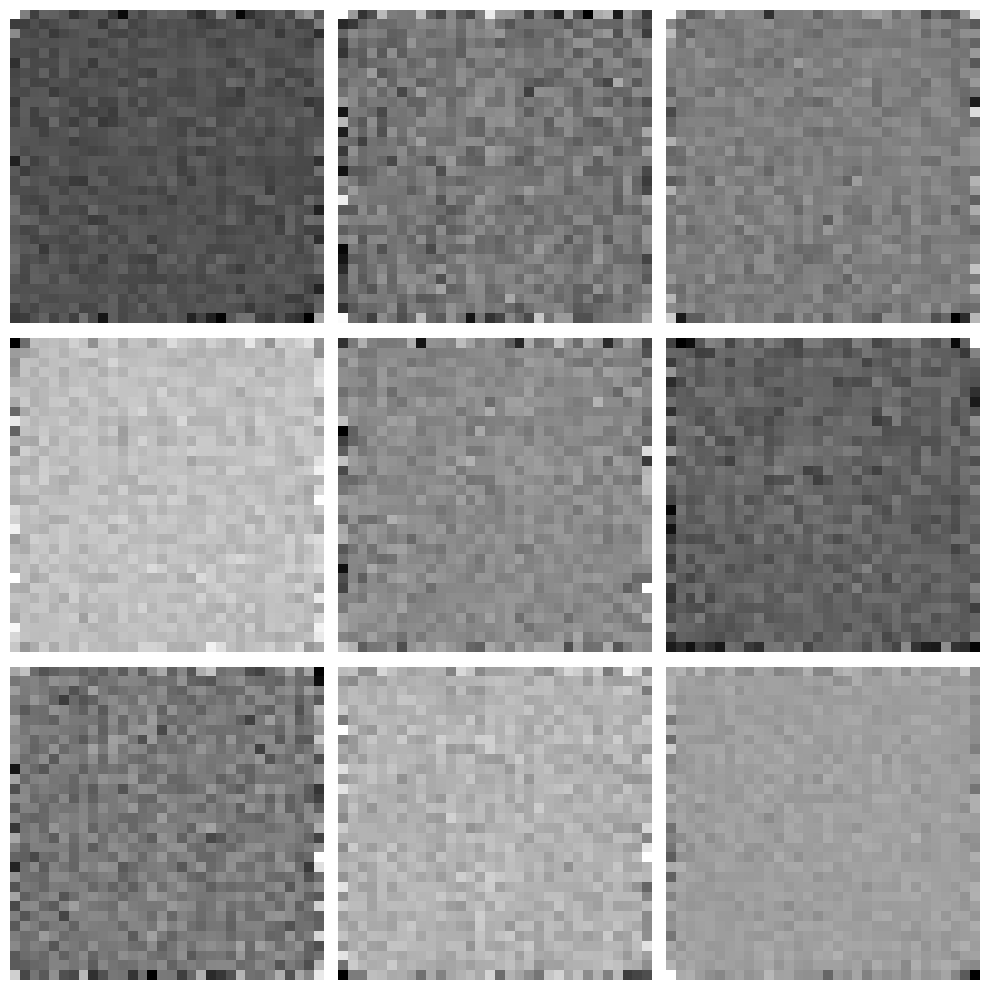

  5%|▌         | 1/20 [02:49<53:42, 169.60s/it]

Showing/saving samples from epoch 1


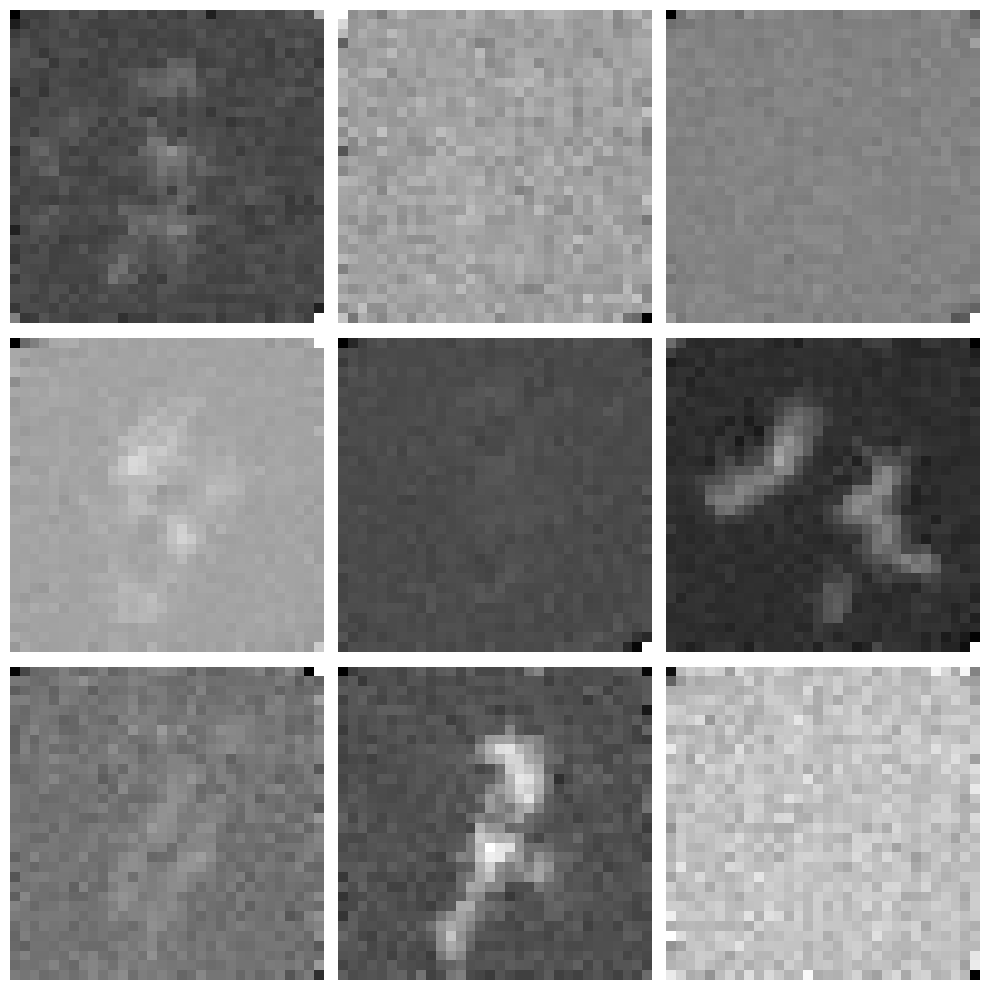

 10%|█         | 2/20 [05:42<51:30, 171.67s/it]

Showing/saving samples from epoch 2


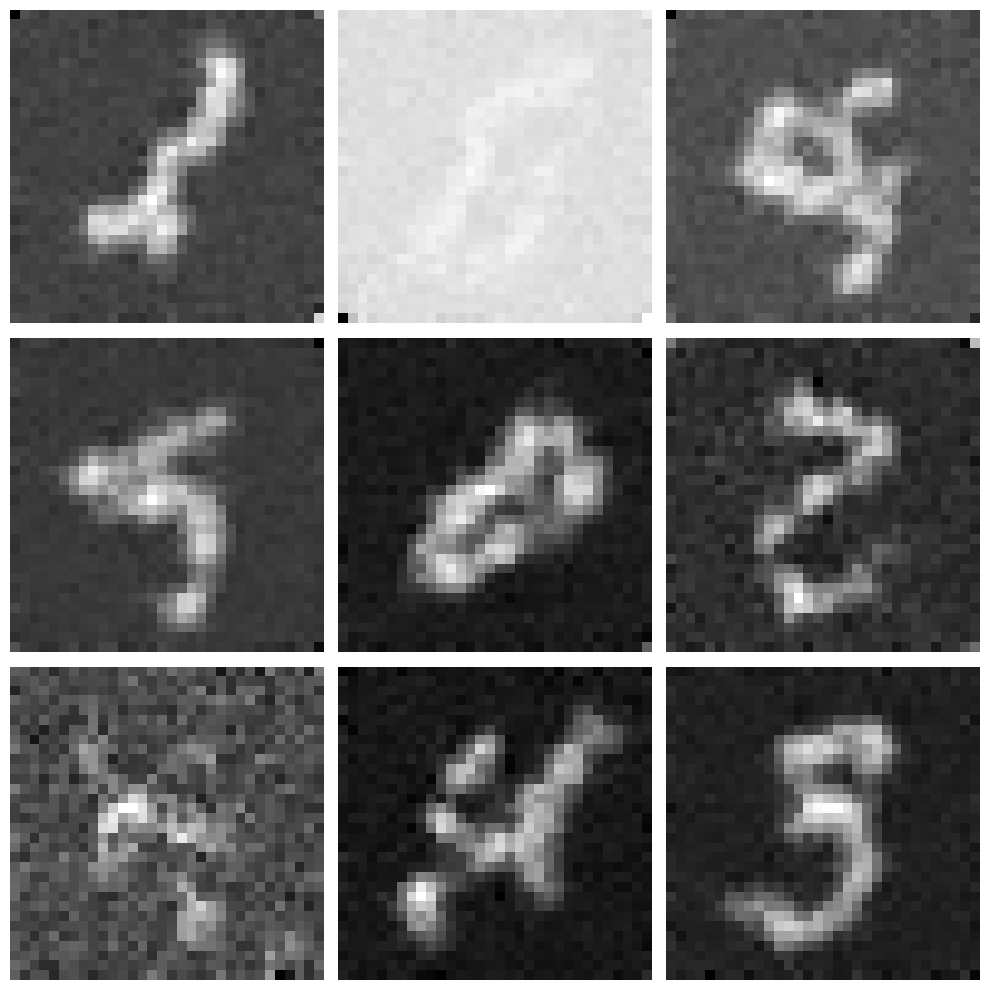

 15%|█▌        | 3/20 [08:35<48:48, 172.25s/it]

Showing/saving samples from epoch 3


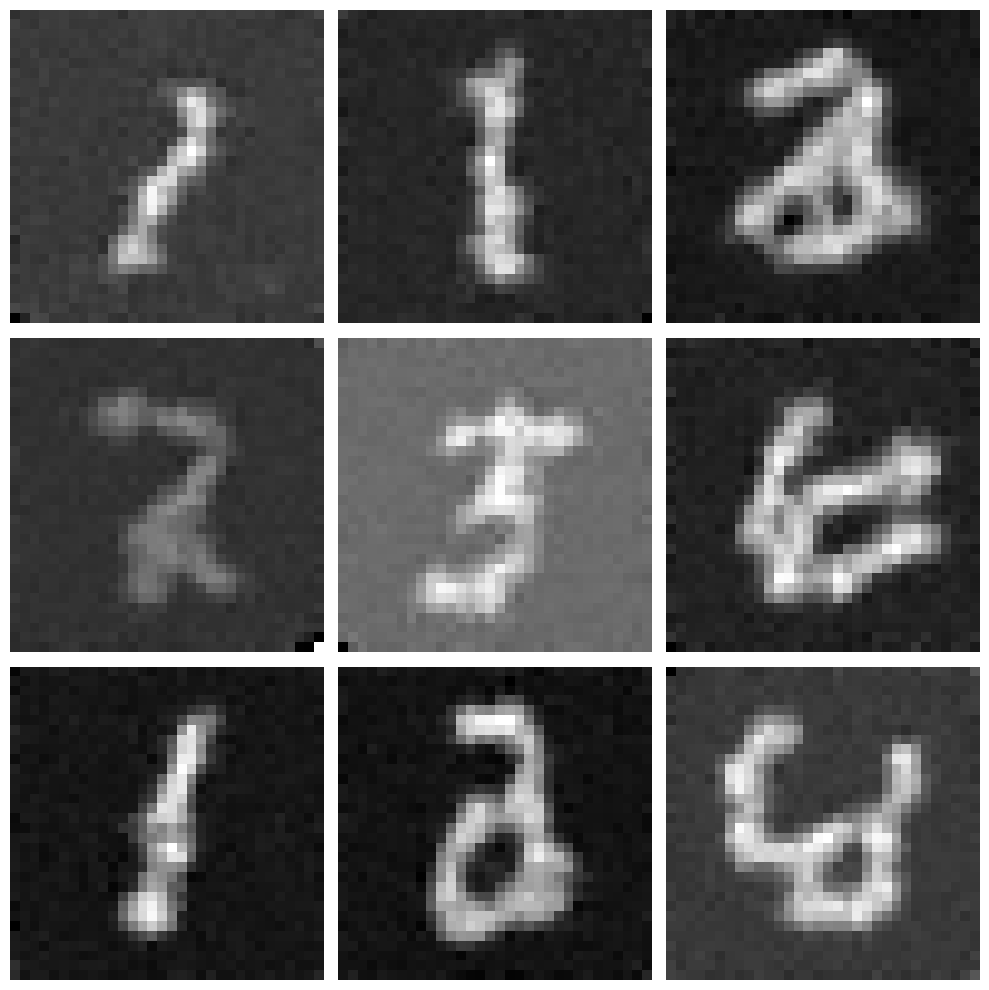

 20%|██        | 4/20 [11:27<45:55, 172.19s/it]

Showing/saving samples from epoch 4


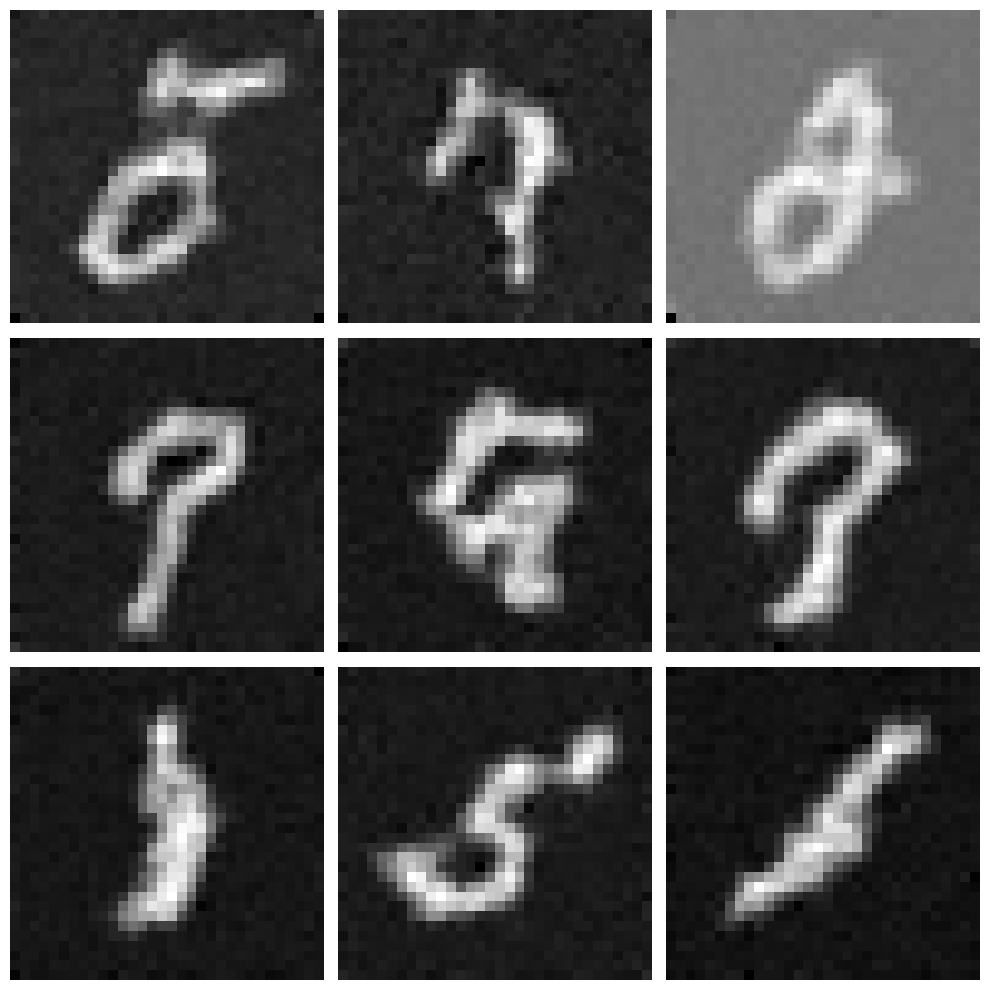

 25%|██▌       | 5/20 [14:20<43:06, 172.46s/it]

Showing/saving samples from epoch 5


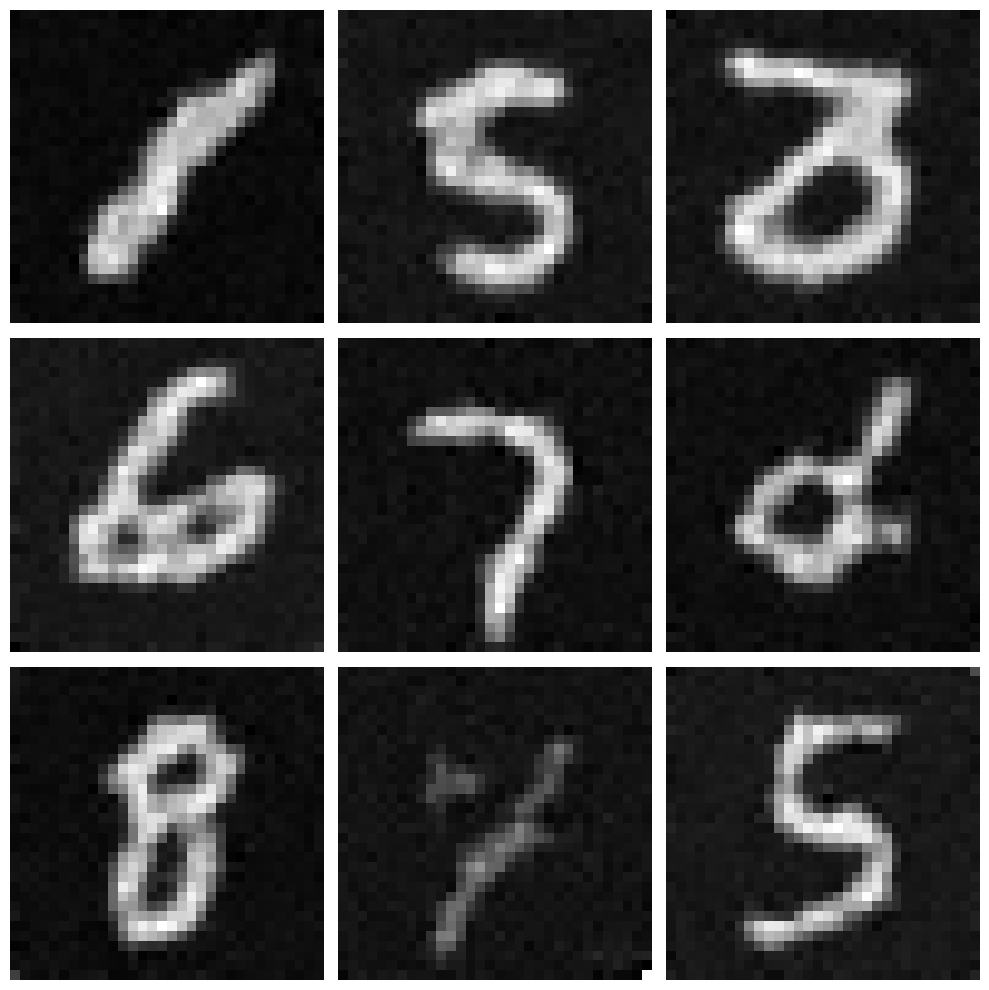

 30%|███       | 6/20 [17:12<40:11, 172.25s/it]

Showing/saving samples from epoch 6


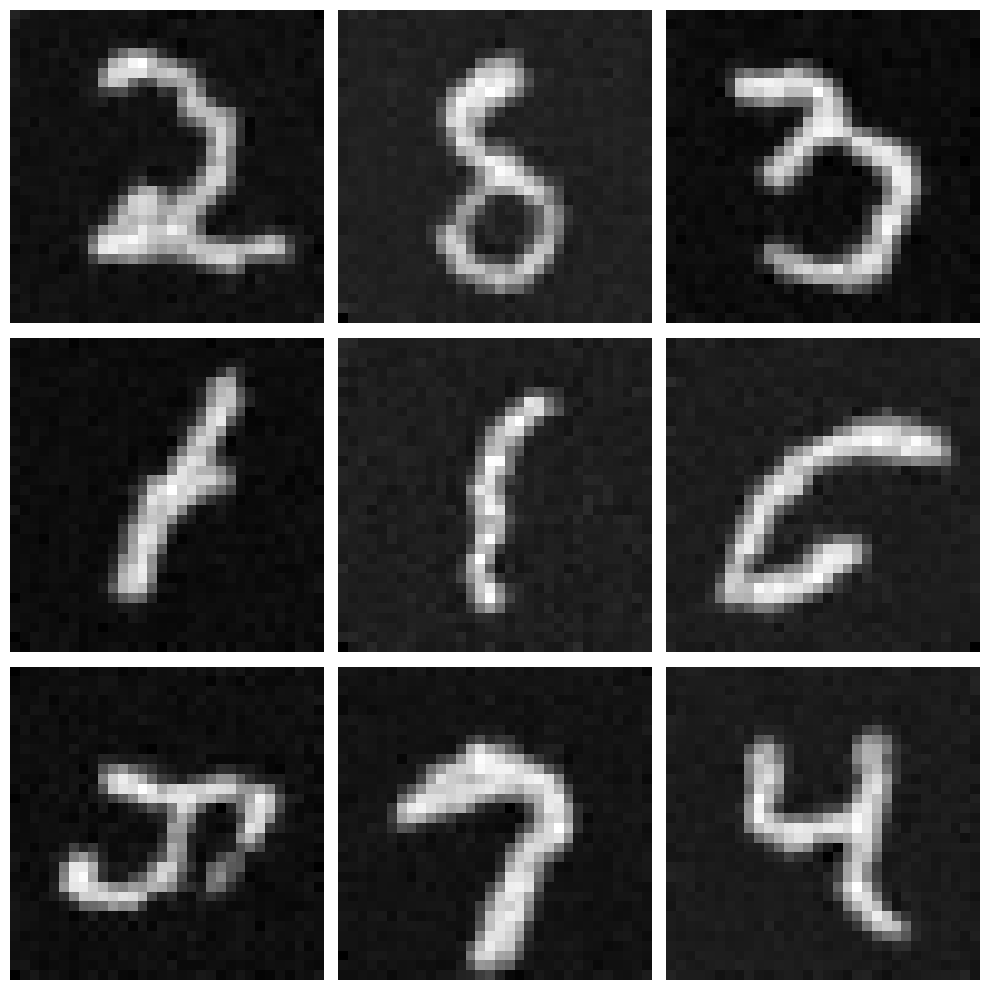

 35%|███▌      | 7/20 [20:04<37:17, 172.11s/it]

Showing/saving samples from epoch 7


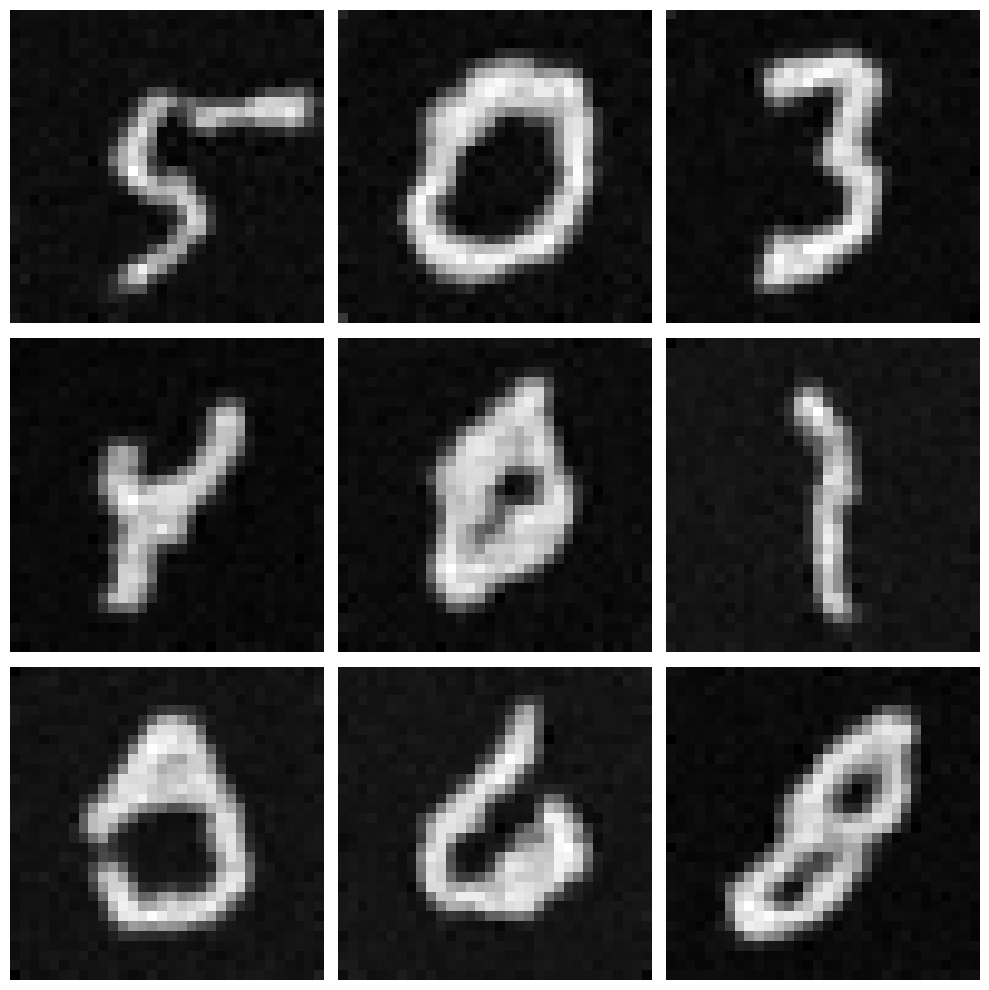

 40%|████      | 8/20 [22:57<34:27, 172.29s/it]

Showing/saving samples from epoch 8


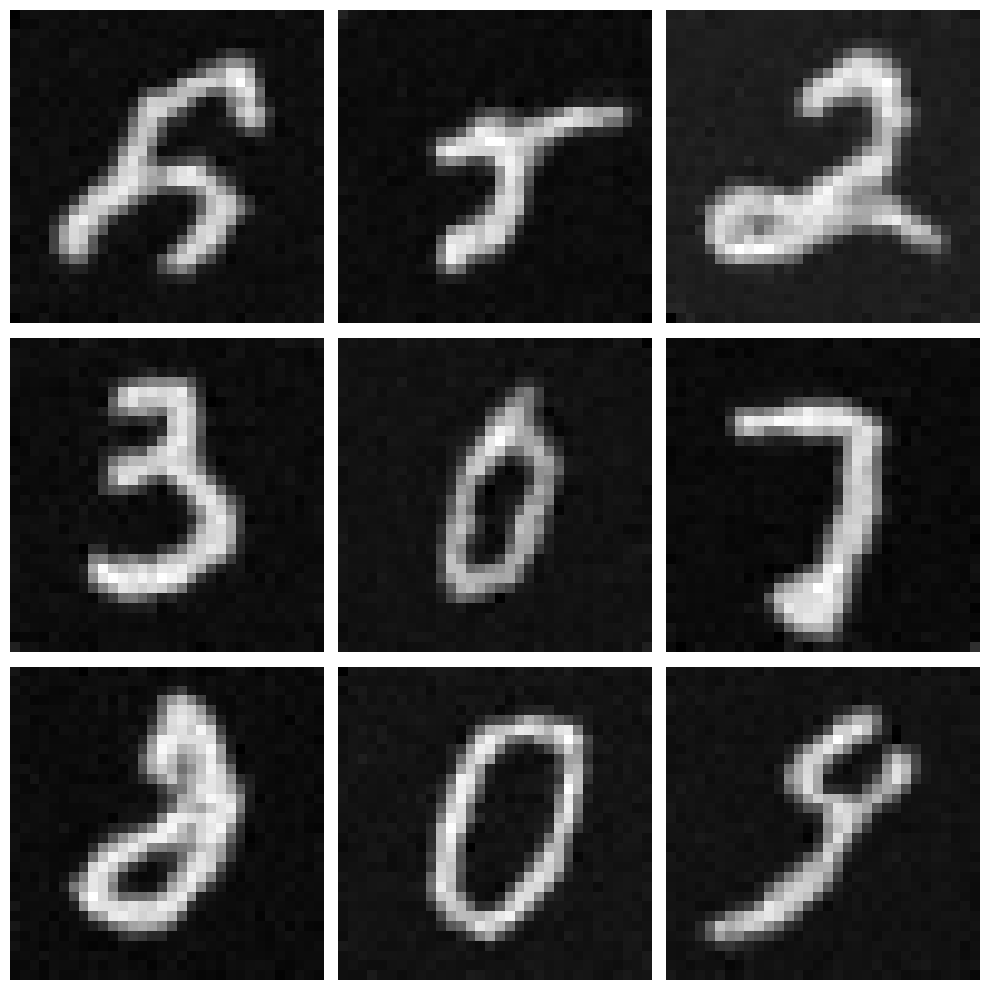

 45%|████▌     | 9/20 [25:49<31:36, 172.44s/it]

Showing/saving samples from epoch 9


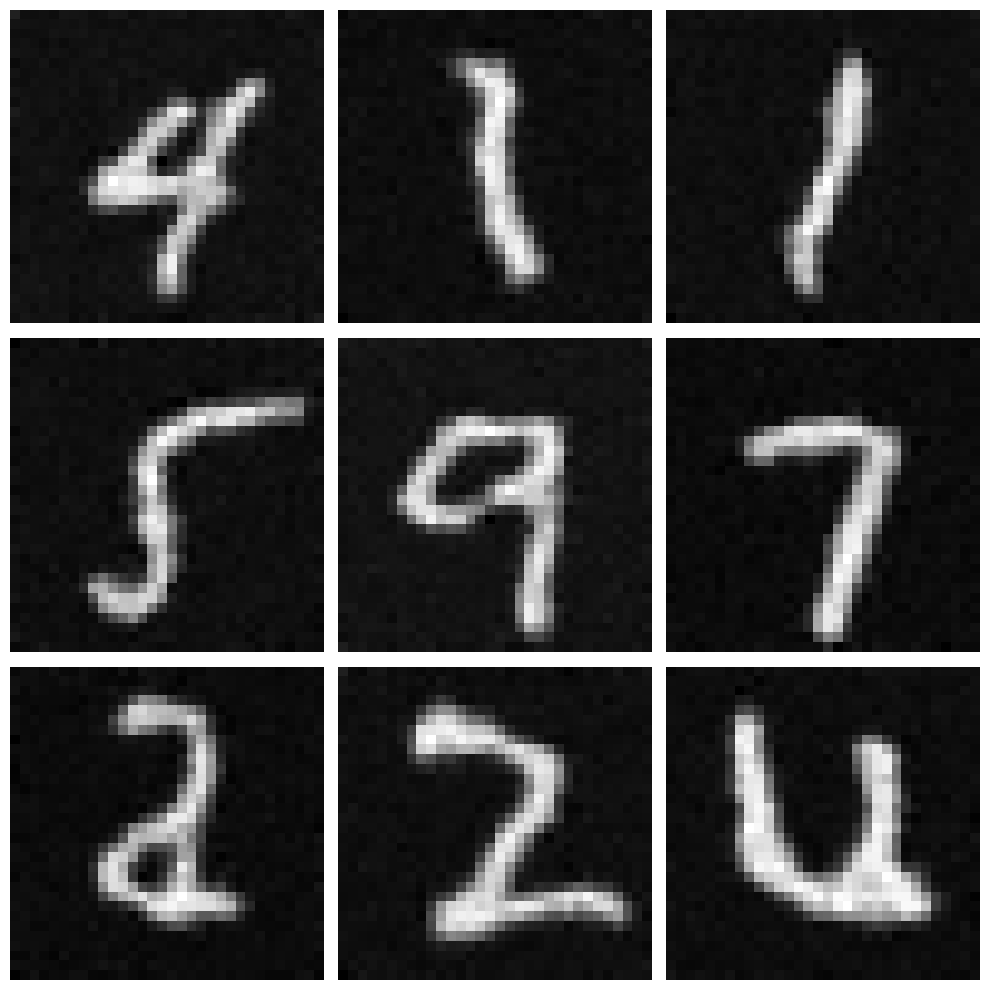

 50%|█████     | 10/20 [28:42<28:45, 172.57s/it]

Showing/saving samples from epoch 10


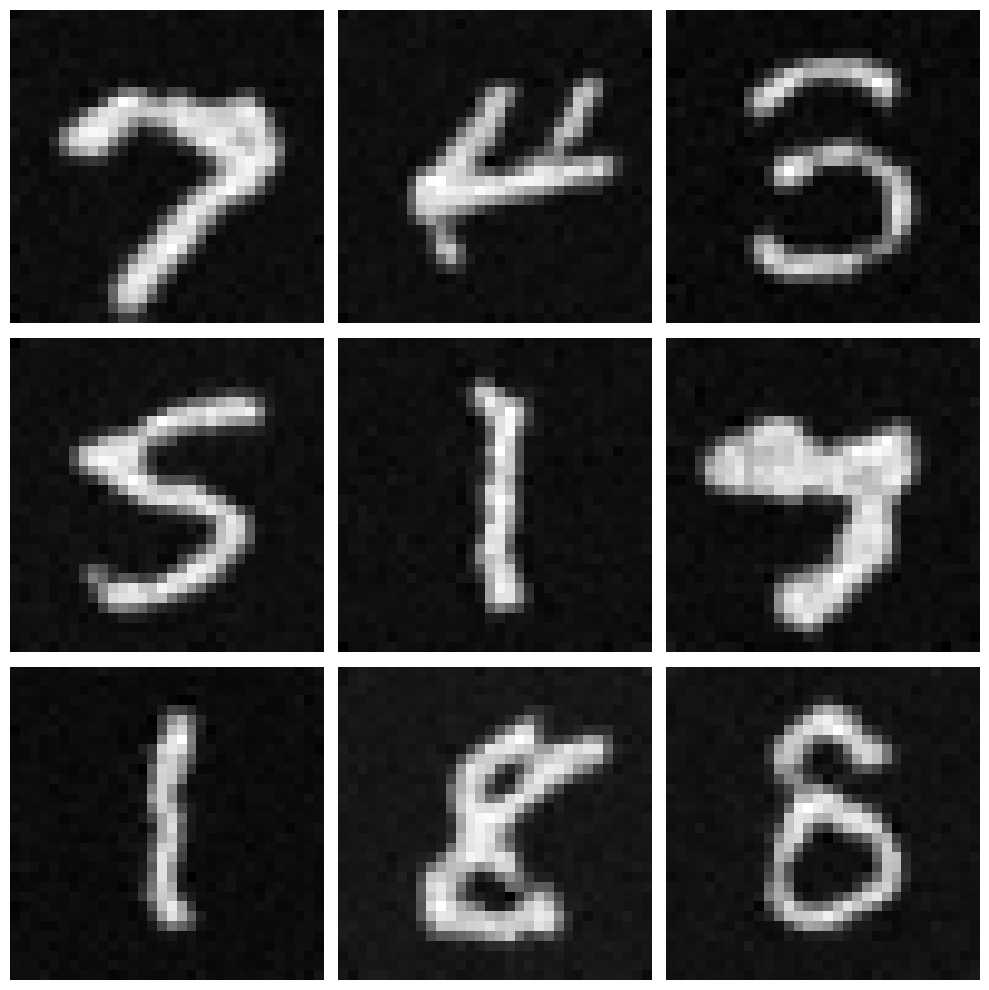

 55%|█████▌    | 11/20 [31:35<25:54, 172.70s/it]

Showing/saving samples from epoch 11


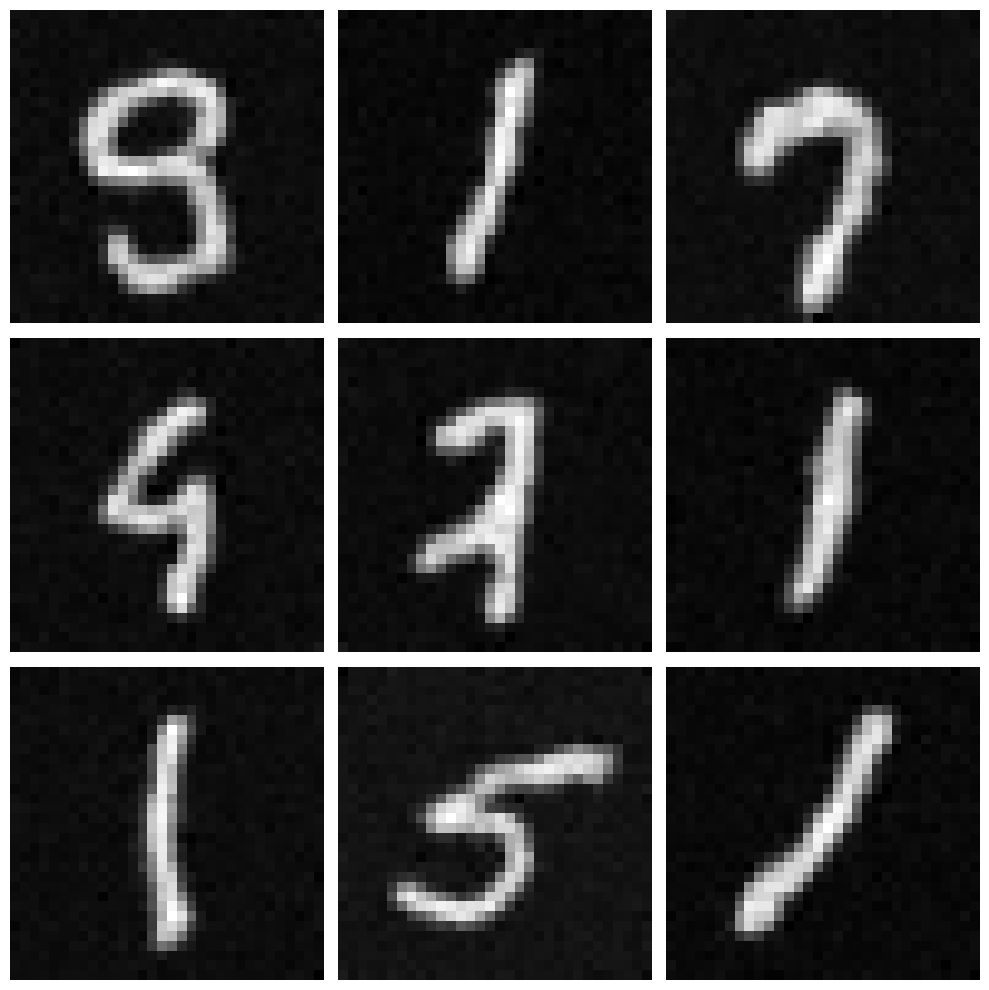

 60%|██████    | 12/20 [34:28<23:00, 172.61s/it]

Showing/saving samples from epoch 12


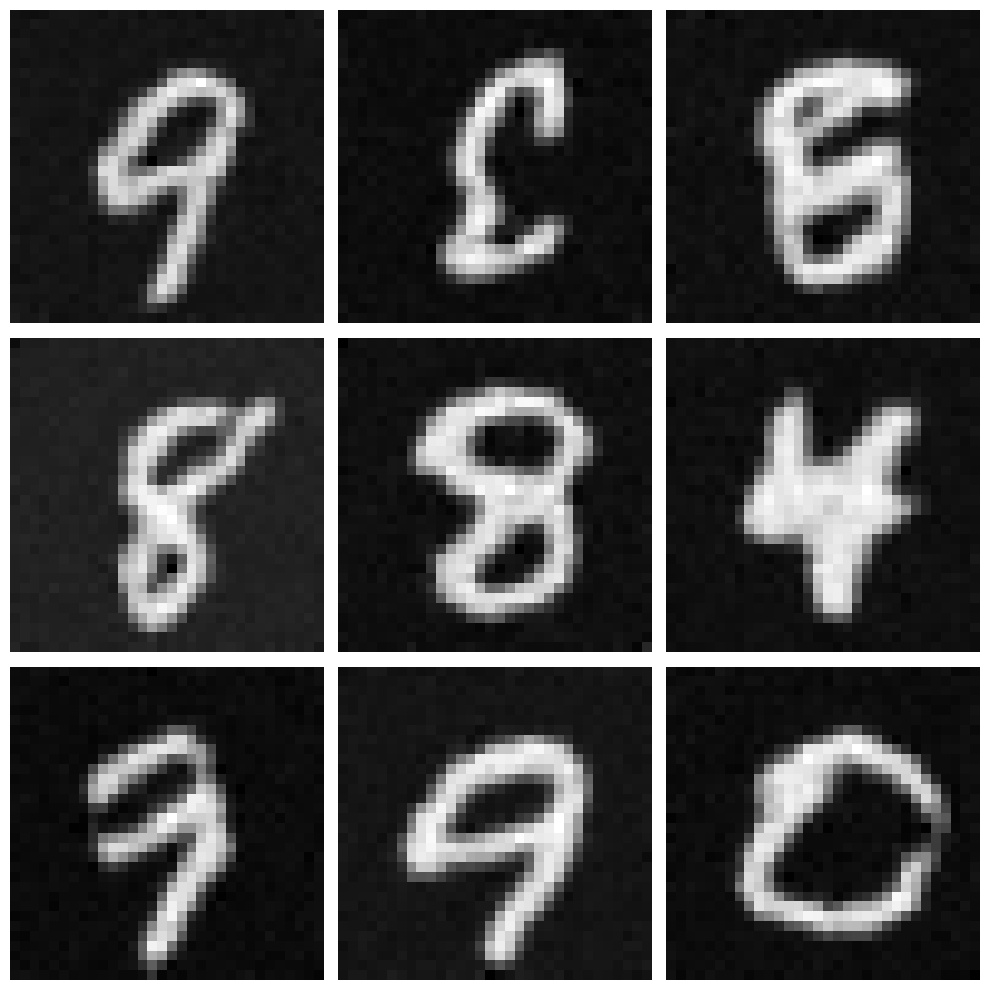

 65%|██████▌   | 13/20 [37:20<20:08, 172.67s/it]

Showing/saving samples from epoch 13


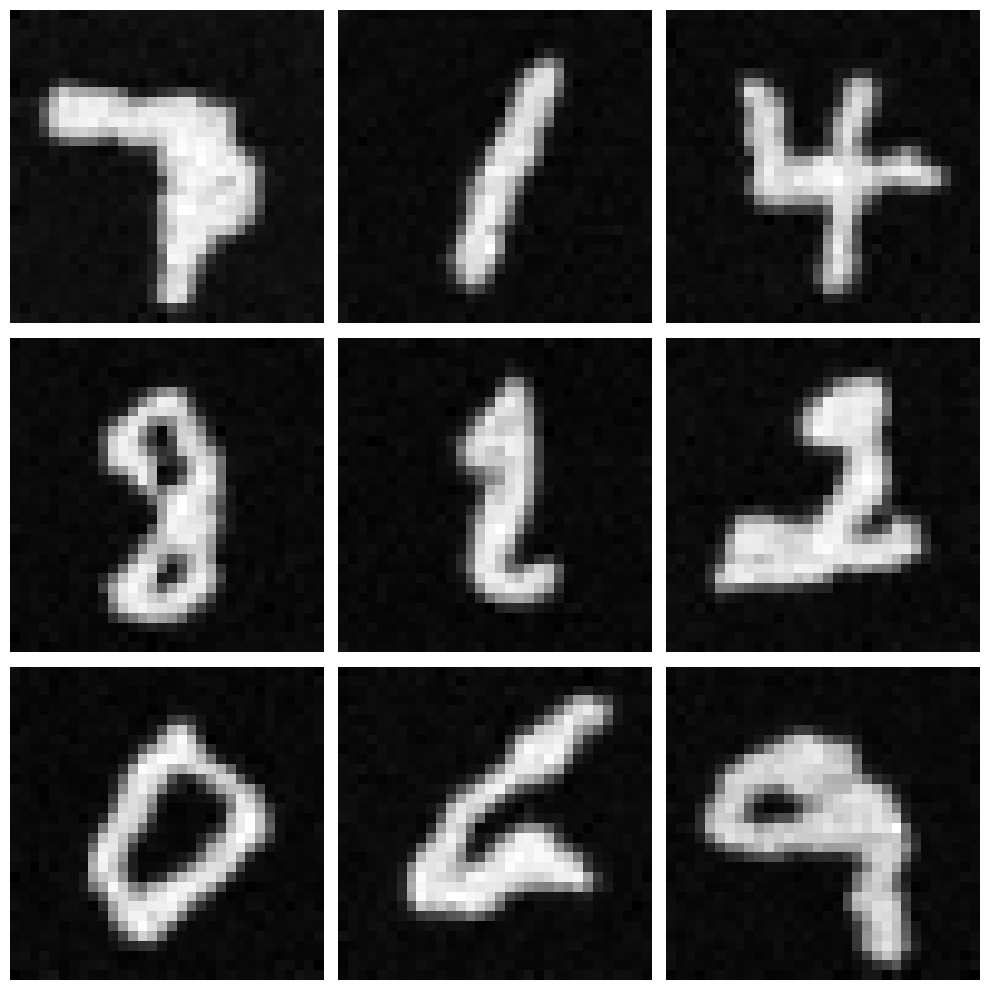

 70%|███████   | 14/20 [40:13<17:15, 172.57s/it]

Showing/saving samples from epoch 14


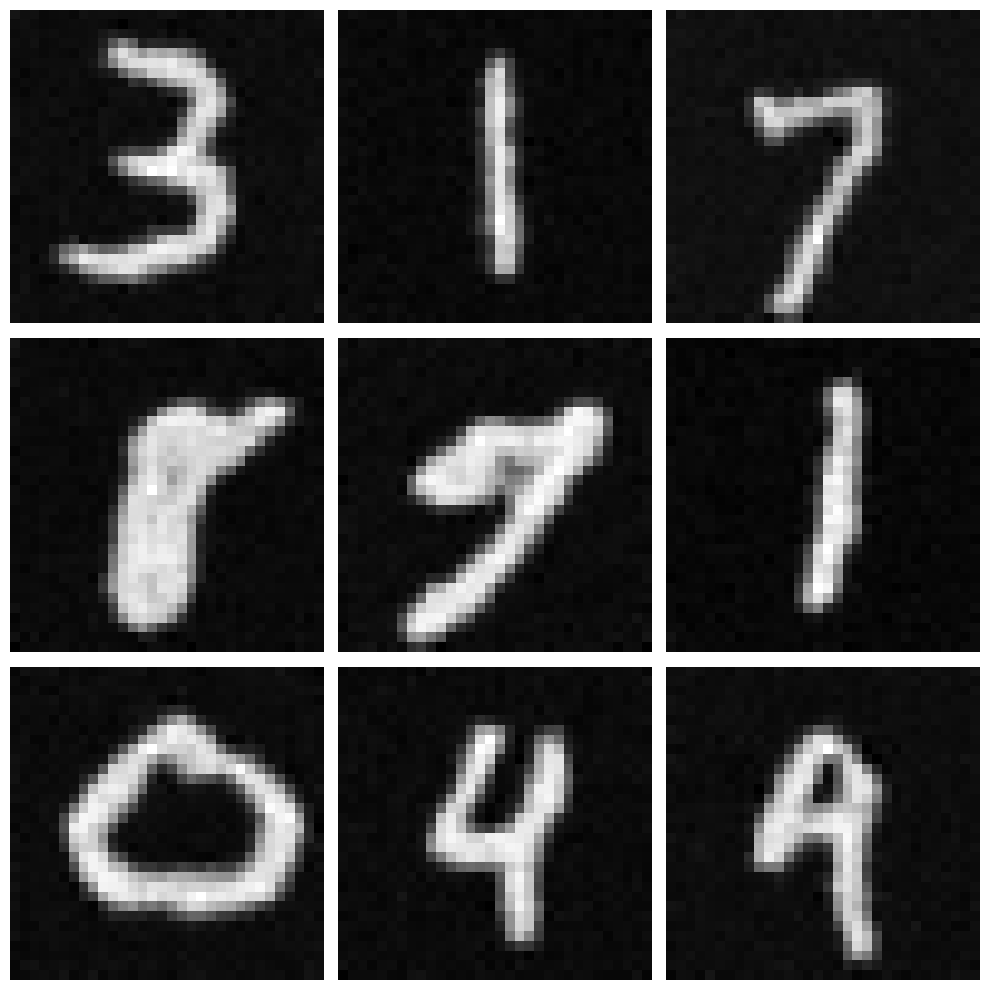

 75%|███████▌  | 15/20 [43:04<14:20, 172.07s/it]

Showing/saving samples from epoch 15


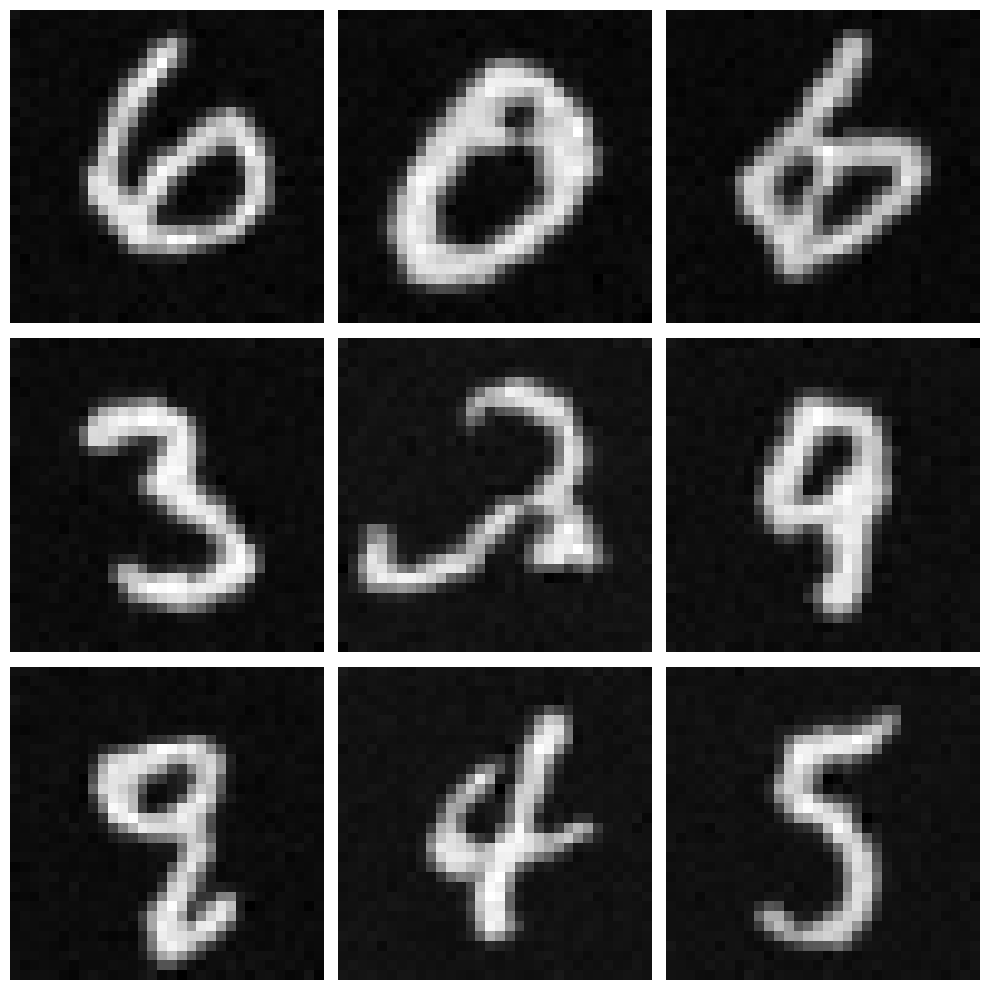

 80%|████████  | 16/20 [45:56<11:28, 172.12s/it]

Showing/saving samples from epoch 16


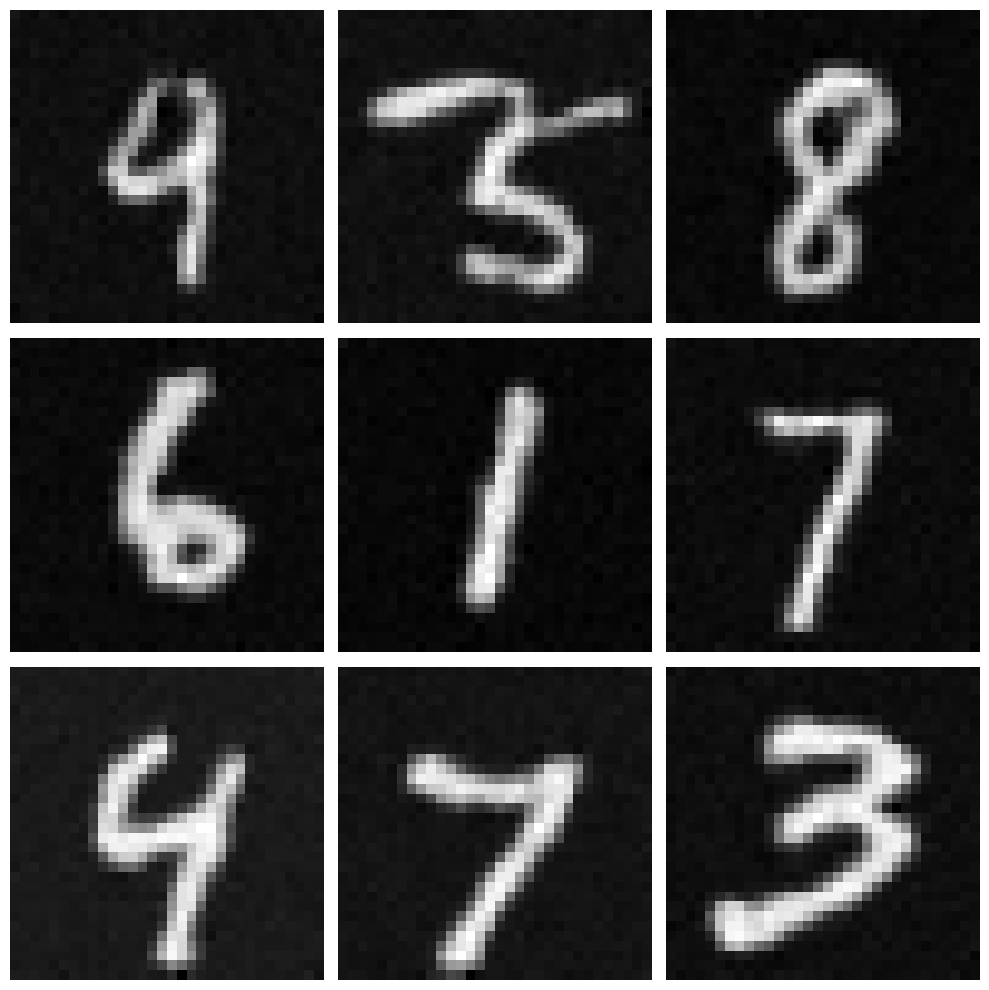

 85%|████████▌ | 17/20 [48:49<08:37, 172.38s/it]

Showing/saving samples from epoch 17


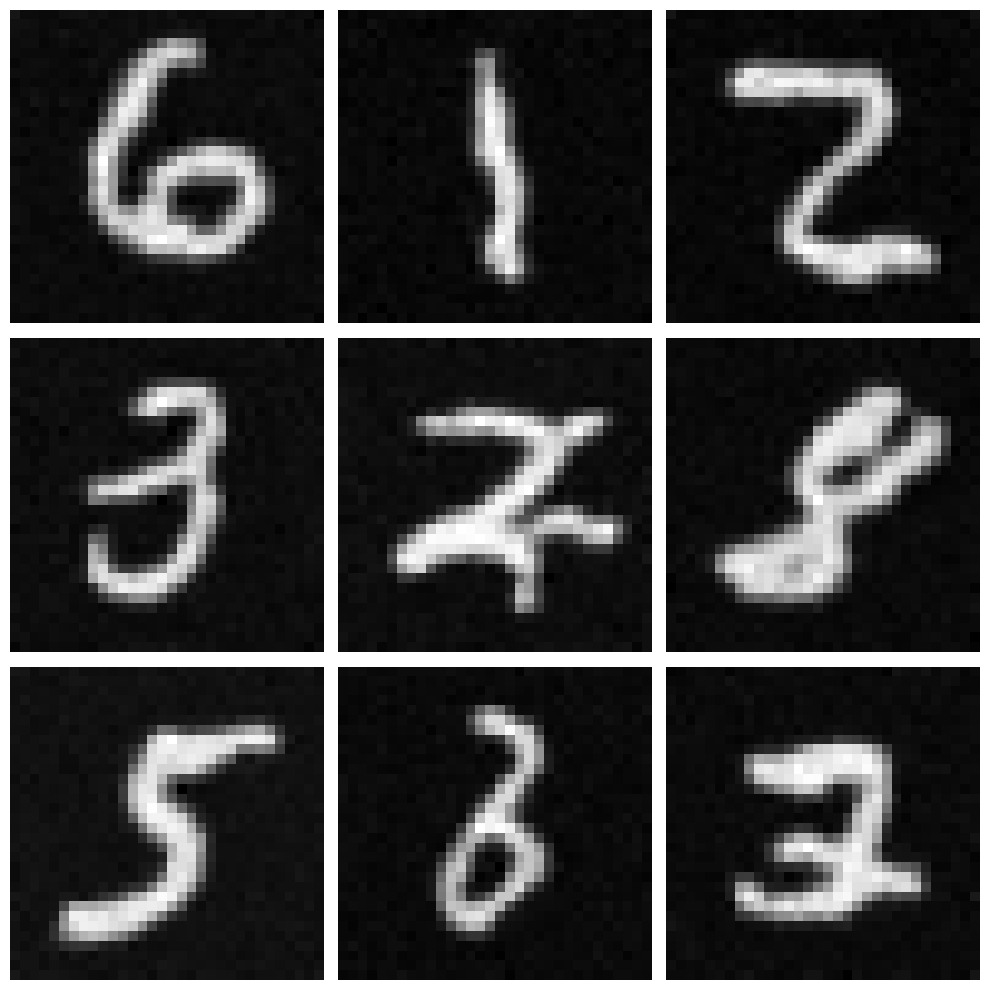

 90%|█████████ | 18/20 [51:41<05:44, 172.41s/it]

Showing/saving samples from epoch 18


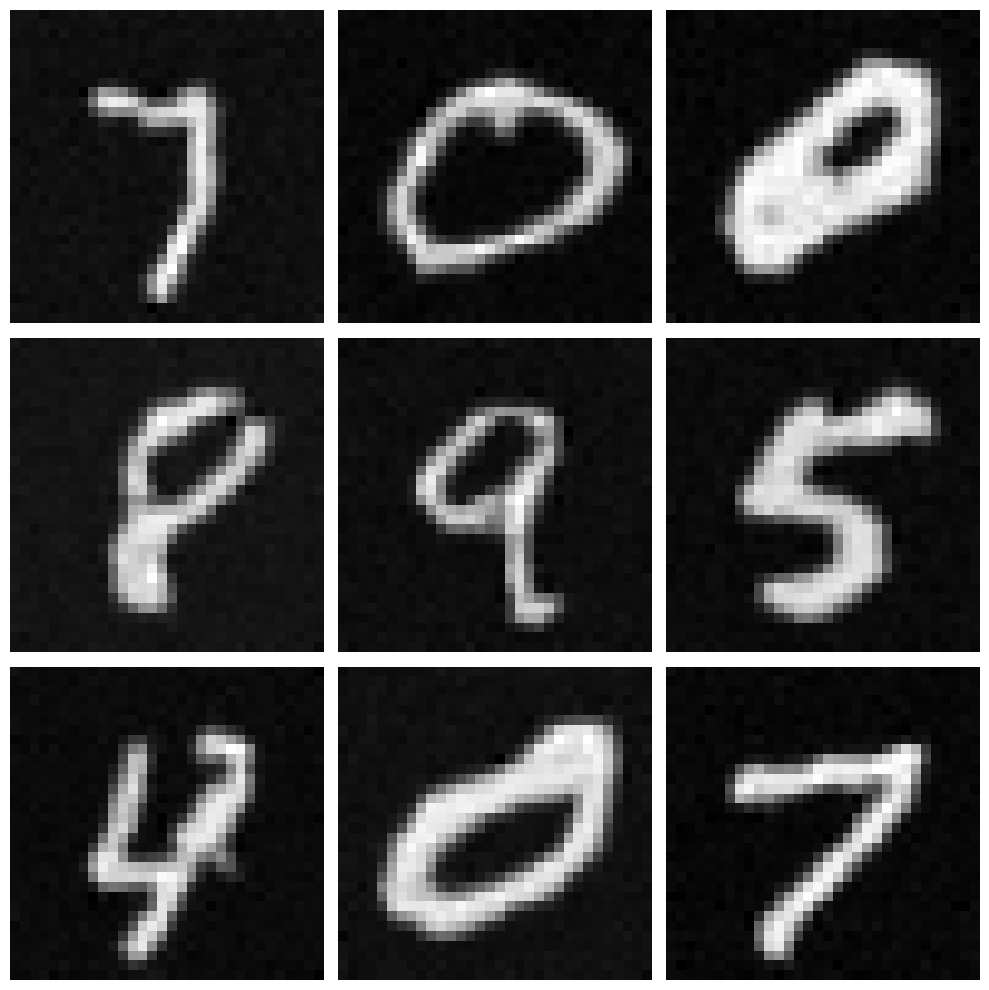

 95%|█████████▌| 19/20 [54:33<02:52, 172.19s/it]

Showing/saving samples from epoch 19


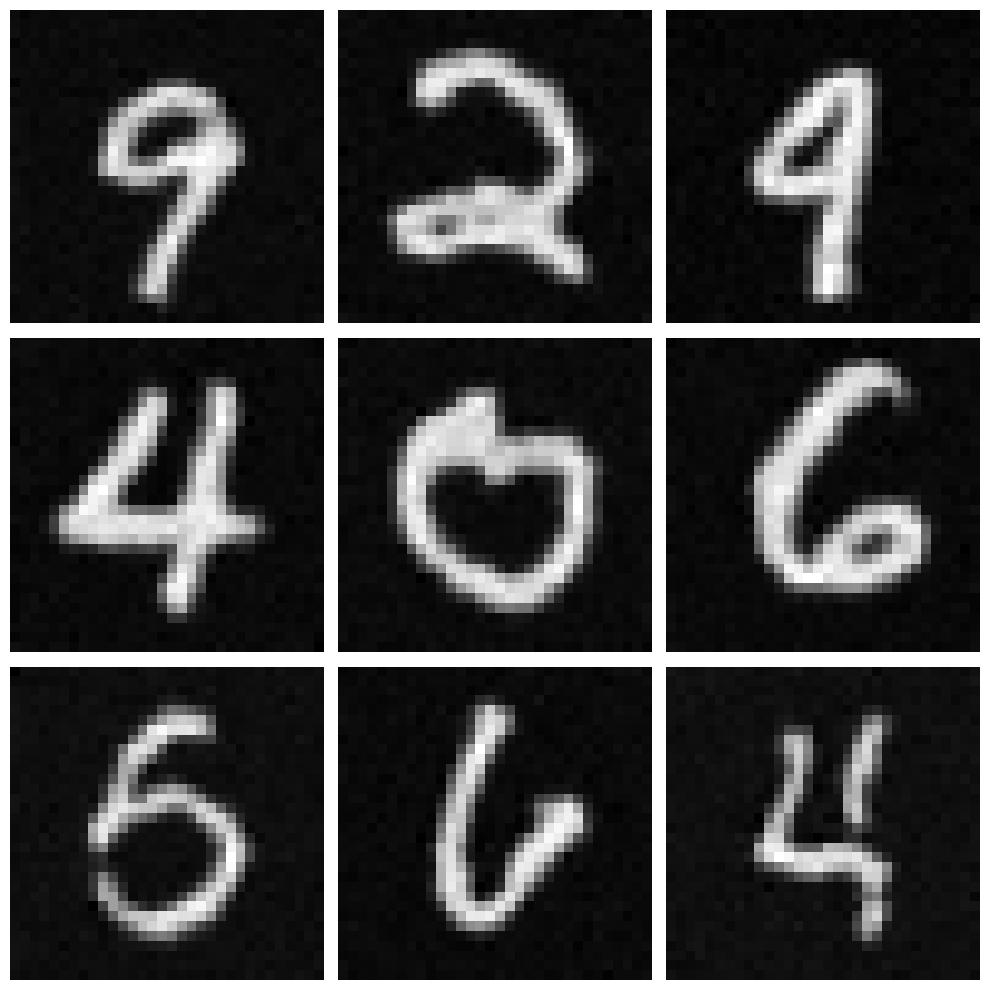

100%|██████████| 20/20 [57:24<00:00, 172.22s/it]


In [5]:
trainer = Trainer(args, DenoiseDiffusion)
dataloader = torch.utils.data.DataLoader(
    MNISTDataset(),
    batch_size=args.batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=4,
    pin_memory=True,
)
trainer.run_in_a_row(dataloader)